In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import plotly.express as px
import plotly as plot
import plotly.graph_objs as go
from plotly.offline import plot
from plotly.subplots import make_subplots

In [2]:
#Define function for cutting pandas dataframe
def temp_dist(raw_data):
    t1_dist=raw_data[['t1']]
    t1_dist=t1_dist.rename(columns={'t1':'t'})
    t1_dist['type']='Temperature'
    t2_dist=raw_data[['t2']]
    t2_dist=t2_dist.rename(columns={'t2':'t'})
    t2_dist['type']='Feel Temperature'
    t_dist=t1_dist.append(t2_dist)
    if t_dist['t'].dtypes==float:
        t_dist['t']=t_dist['t'].round(1)
    return t_dist

In [4]:
raw=pd.read_csv("london_merged.csv")

In [5]:
#Data shape
print(raw.shape)

(17414, 10)


In [6]:
#description
print(raw.describe())

                cnt            t1            t2           hum    wind_speed  \
count  17414.000000  17414.000000  17414.000000  17414.000000  17414.000000   
mean    1143.101642     12.468091     11.520836     72.324954     15.913063   
std     1085.108068      5.571818      6.615145     14.313186      7.894570   
min        0.000000     -1.500000     -6.000000     20.500000      0.000000   
25%      257.000000      8.000000      6.000000     63.000000     10.000000   
50%      844.000000     12.500000     12.500000     74.500000     15.000000   
75%     1671.750000     16.000000     16.000000     83.000000     20.500000   
max     7860.000000     34.000000     34.000000    100.000000     56.500000   

       weather_code    is_holiday    is_weekend        season  
count  17414.000000  17414.000000  17414.000000  17414.000000  
mean       2.722752      0.022051      0.285403      1.492075  
std        2.341163      0.146854      0.451619      1.118911  
min        1.000000      0.00000

In [7]:
#check if any cell is nan
raw.isna().values.any()

False

In [8]:
#Define weather code according to web's information
weather_info=pd.DataFrame({'code':[1, 2, 3, 4, 7, 10, 26, 94], 
                          'weather':['Clear', 
                          'Scatter', 
                          'Broken', 
                          'Cloudy',
                          'Rainy', 
                          'Thunder', 
                          'Snowfall', 
                          'Freeze']})
raw=pd.merge(raw, weather_info, how='left',left_on='weather_code', right_on='code')

In [9]:
#data process: timestamp
raw['timestamp']=pd.to_datetime(raw.timestamp)
raw['hour']=pd.DatetimeIndex(raw['timestamp']).hour
raw['month']=pd.DatetimeIndex(raw['timestamp']).month
raw['year']=pd.DatetimeIndex(raw['timestamp']).year
#understand the data time range
print(raw['timestamp'].describe())

count                   17414
unique                  17414
top       2015-09-21 23:00:00
freq                        1
first     2015-01-04 00:00:00
last      2017-01-03 23:00:00
Name: timestamp, dtype: object


In [10]:
#Define plot style
sns.set_style("ticks")

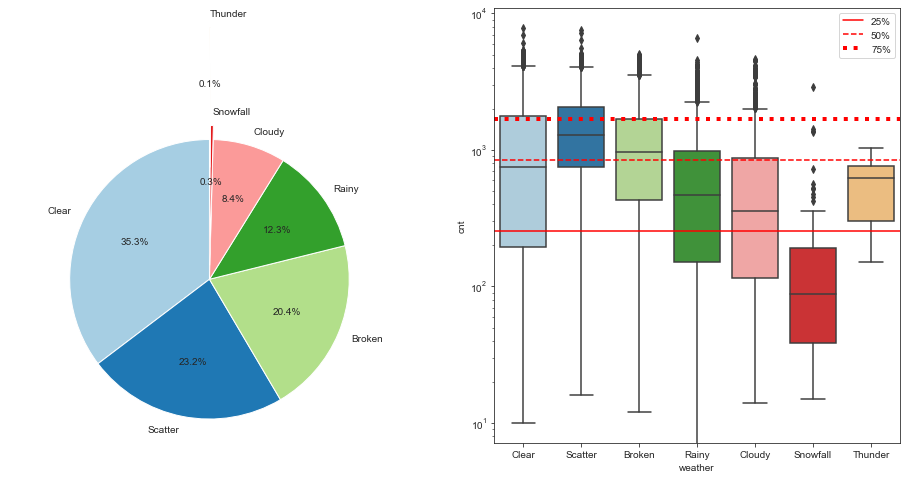

In [11]:
#weather hour distribution
weather_count=raw.groupby('weather').size().to_frame('hour').sort_values(by=['hour'], ascending=False).reset_index()
explode = (0, 0, 0, 0, 0, 0.1, 0.8)
fig, ax = plt.subplots(1,2, figsize=(16,8))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)
ax[0].pie(x=weather_count['hour'],
          labels=weather_count['weather'],
          autopct='%1.1f%%',
          colors=sns.color_palette('Paired'),
          explode=explode,startangle = 90
          ) #[0:weather_count.shape[0]]
ax[0].axis('equal')
sns.catplot(x='weather', y='cnt',
            kind="box",
            data=raw,
            order=weather_count['weather'], 
            palette='Paired',
            ax=ax[1]
    )
ax[1].set_yscale('log')
ax[1].axhline(float(raw[['cnt']].quantile(q=0.25)), c='red', label="25%")
ax[1].axhline(float(raw[['cnt']].quantile(q=0.5)), ls='--',  c='red',label="50%")
ax[1].axhline(float(raw[['cnt']].quantile(q=0.75)), ls=':', linewidth=4, c='red',label="75%")
labels = [ "25%", '50%', '75%']
handles, _ = ax[1].get_legend_handles_labels()
ax[1].legend(handles = handles, labels = labels)
plt.close(2)

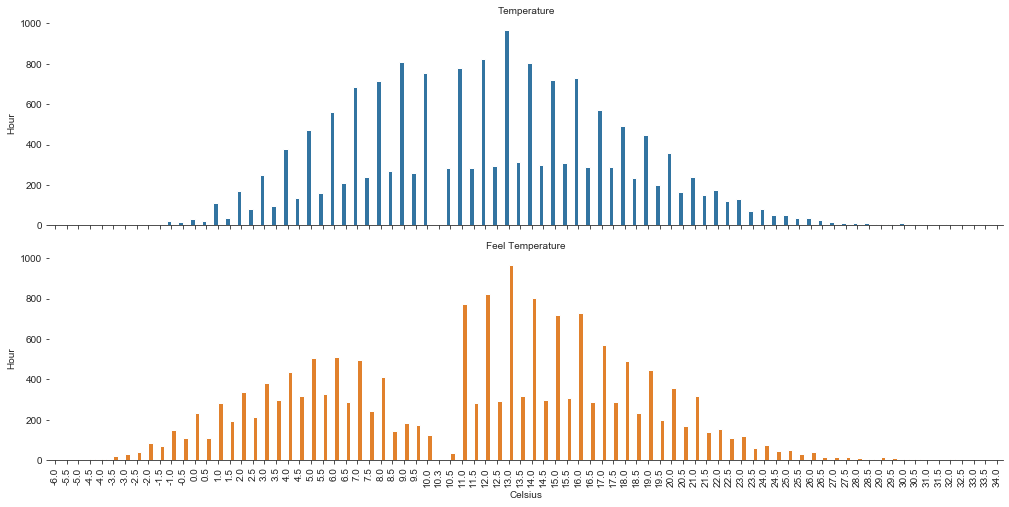

In [12]:
#t1 and t2 raw distribution. The plots show that 0.5 degree x-axis has less hours than integer degree. 
#A weird temperature degree at 10.3 
temp_raw_data=raw[['t1', 't2']]
t_dist=temp_dist(temp_raw_data)
g=sns.catplot(data=t_dist,
              x='t',
              row='type',
              hue='type',
              kind='count',
              height=3.5,
              aspect=4
              )
g.set_axis_labels("Celsius", "Hour")
g.set_titles("{row_name}")
g.despine(left=True)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

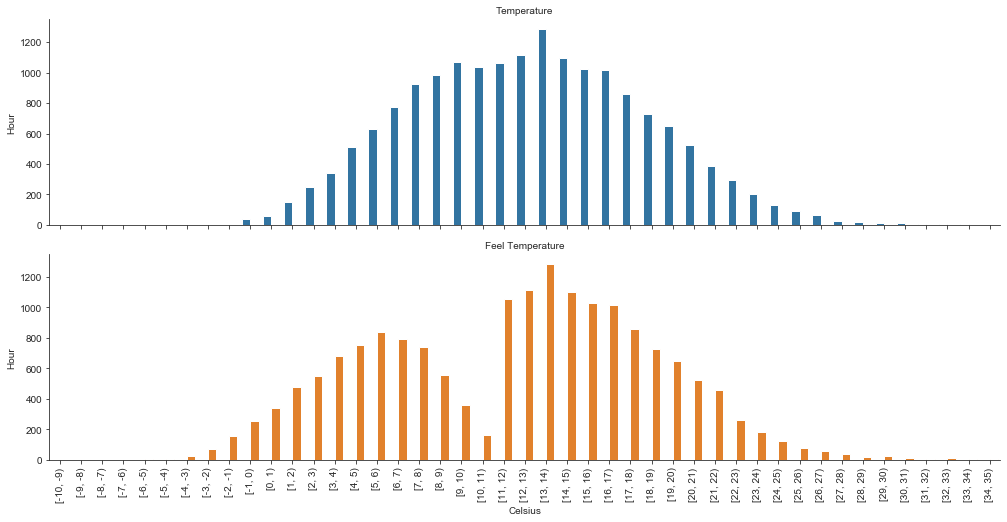

In [13]:
#Group temperature to one interval and replot
min_value=-10
max_value=35
interval=1
raw['t1_cut1']=pd.cut(raw['t1'],
                        bins=pd.interval_range(start=min_value, 
                                               end=max_value, 
                                               freq=interval, 
                                               closed='left')#,
                    )
raw['t2_cut1']=pd.cut(raw['t2'],
                        bins=pd.interval_range(start=min_value, 
                                               end=max_value, 
                                               freq=interval, 
                                               closed='left')#,
                    )

raw_data=raw[['t1_cut1', 't2_cut1']]
raw_data=raw_data.rename(columns={'t1_cut1':'t1', 't2_cut1':'t2'})
t_dist=temp_dist(raw_data)

g=sns.catplot(data=t_dist,
              x='t',
              row='type',
              hue='type',
              kind='count',
              height=3.5,
              aspect=4
              )
g.set_axis_labels("Celsius", "Hour")
g.set_titles("{row_name}")
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

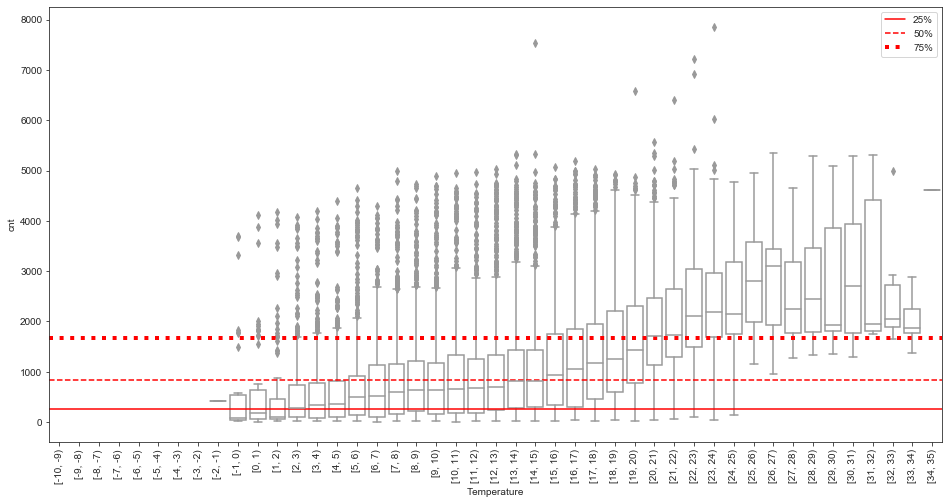

In [15]:
#See the relationship between cnt and t1
fig, ax = plt.subplots( figsize=(16,8))
sns.boxplot(
    data=raw, 
    x='t1_cut1',
    y='cnt',
    color='white',
    ax=ax
    )
ax.set(xlabel='Temperature')
ax.axhline(float(raw[['cnt']].quantile(q=0.25)), c='red', label="25%")
ax.axhline(float(raw[['cnt']].quantile(q=0.5)), ls='--',  c='red',label="50%")
ax.axhline(float(raw[['cnt']].quantile(q=0.75)), ls=':', linewidth=4, c='red',label="75%")
for label in ax.get_xticklabels():
    label.set_rotation(90)
labels = [ "25%", '50%', '75%']
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles = handles, labels = labels)


In [46]:
#Relationship between weather and temperature
min_value=-10
max_value=35
interval=5
raw['t1_cut5']=pd.cut(raw['t1'],
                        bins=pd.interval_range(start=min_value, end=max_value, freq=interval, closed='left')#,
                        #labels=label_layout
                    )
fig = make_subplots(rows=4, cols=2,specs=[[{"type": "domain"},
                                          {"type": "domain"}],
                                          [{"type": "domain"}, 
                                           {"type": "domain"}],
                                          [{"type": "domain"},
                                          {"type": "domain"}],
                                          [{"type": "domain"},
                                           {"type": "domain"}]
                                          ],
                    subplot_titles=weather_count['weather'])
for i in list(range(weather_count.shape[0])):
    name=weather_count['weather'][i]
    df=raw[(raw['weather']== name)]
    df=df.rename(columns={'t1_cut5':'Temperature'})
    labels = df.Temperature.value_counts(sort=False).index.astype(str)
    values = df.Temperature.value_counts(sort=False).values
    r=int(i/2)+1
    c=(i%2)+1
    fig.add_trace(go.Pie(labels=labels, values=values, name=name, textinfo='label+percent'),
                  row=r, col=c)
fig.update_layout(showlegend=False, autosize = True, height=2000)
fig.show() 

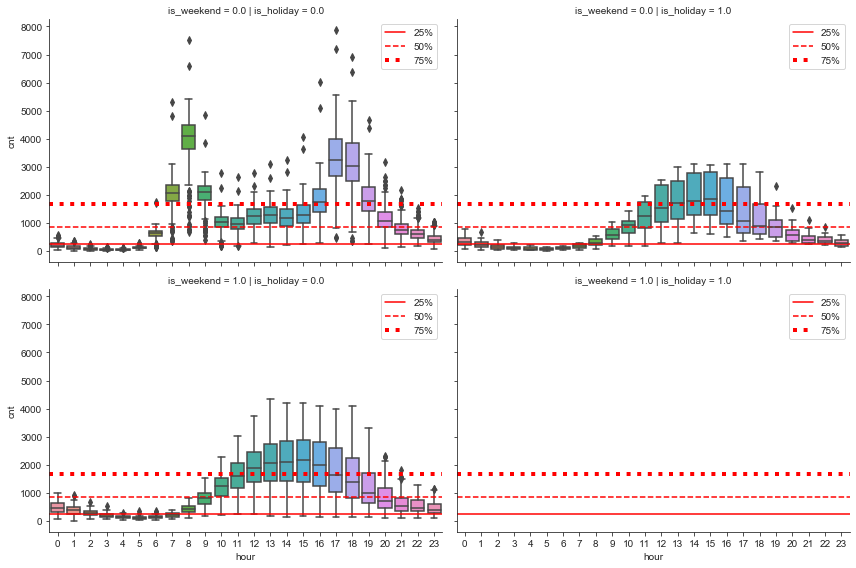

In [38]:
#Hour and cnt distribution
#Cnt has high peak hour in workdays, 7-9 and 17-18 hour
#THe distribution at holiday or weekend is similar. high cnt is between 12 and 17 hour
g=sns.catplot(data=raw,
              x='hour',
              y='cnt',
              col='is_holiday',
              row='is_weekend',
              kind="box",
              height=4,
              aspect=1.5
              )
labels = [ "25%", '50%', '75%']
for ax in g.axes.flat:
    ax.axhline(float(raw[['cnt']].quantile(q=0.25)), c='red', label="25%")
    ax.axhline(float(raw[['cnt']].quantile(q=0.5)), ls='--',  c='red',label="50%")
    ax.axhline(float(raw[['cnt']].quantile(q=0.75)), ls=':', linewidth=4, c='red',label="75%")
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles = handles, labels = labels)